# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size_and_log"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.009162,0.009555,-0.958926,0.337632,0.831184,random.pheno988
1,LV2,0.027444,0.012462,2.202239,0.027684,0.013842,random.pheno988
2,LV3,-0.011321,0.012300,-0.920410,0.357393,0.821304,random.pheno988
3,LV4,-0.014100,0.011958,-1.179103,0.238401,0.880800,random.pheno988
4,LV5,0.005783,0.012751,0.453493,0.650209,0.325105,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.05510840932117528

# QQ-plot

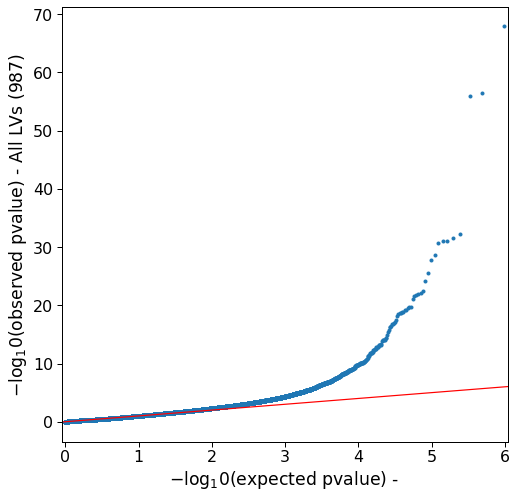

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.027,0.068
1,LV10,0.007,0.050,0.087
2,LV100,0.004,0.023,0.042
3,LV101,0.008,0.044,0.082
4,LV102,0.016,0.061,0.105


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016329,0.055108,0.098846
std,0.018277,0.033454,0.047415
min,0.000000,0.000000,0.000000
25%,0.008000,0.041000,0.081000
50%,0.014000,0.056000,0.102000
75%,0.020000,0.069000,0.123000
max,0.243000,0.340000,0.403000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(53, 4)

,lv,1,5,10
395,LV455,0.011,0.049,0.089
922,LV93,0.011,0.049,0.111
905,LV914,0.008,0.049,0.126
747,LV772,0.009,0.049,0.087
451,LV505,0.011,0.049,0.094
443,LV499,0.010,0.049,0.097
390,LV450,0.012,0.049,0.097
380,LV441,0.009,0.049,0.096
298,LV368,0.010,0.049,0.081
294,LV364,0.011,0.049,0.085


,lv,1,5,10
84,LV175,0.010,0.050,0.089
940,LV946,0.014,0.050,0.086
257,LV330,0.013,0.050,0.092
669,LV701,0.010,0.050,0.103
944,LV95,0.008,0.051,0.098
857,LV871,0.011,0.051,0.101
15,LV112,0.014,0.051,0.107
166,LV249,0.011,0.051,0.087
661,LV695,0.011,0.051,0.102
648,LV683,0.012,0.051,0.089


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(389, 4)

,lv,1,5,10
743,LV769,0.050,0.140,0.223
403,LV462,0.054,0.145,0.237
398,LV458,0.069,0.151,0.202
129,LV215,0.073,0.169,0.232
153,LV237,0.090,0.175,0.246
349,LV413,0.106,0.176,0.228
255,LV329,0.137,0.183,0.212
965,LV969,0.107,0.187,0.268
682,LV713,0.106,0.191,0.249
401,LV460,0.111,0.194,0.251


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017220,0.010313,1.669739,0.095020,0.047510,random.pheno988
1031,LV45,0.010713,0.010317,1.038317,0.299162,0.149581,random.pheno589
2018,LV45,0.005123,0.010313,0.496778,0.619363,0.309681,random.pheno385
3005,LV45,0.006684,0.010305,0.648567,0.516641,0.258321,random.pheno5
3992,LV45,-0.016236,0.010301,-1.576186,0.115032,0.942484,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.022

In [32]:
show_prop(results, 0.05)

0.064

In [33]:
show_prop(results, 0.10)

0.122

In [34]:
show_prop(results, 0.15)

0.166

In [35]:
show_prop(results, 0.20)

0.204

### QQplot

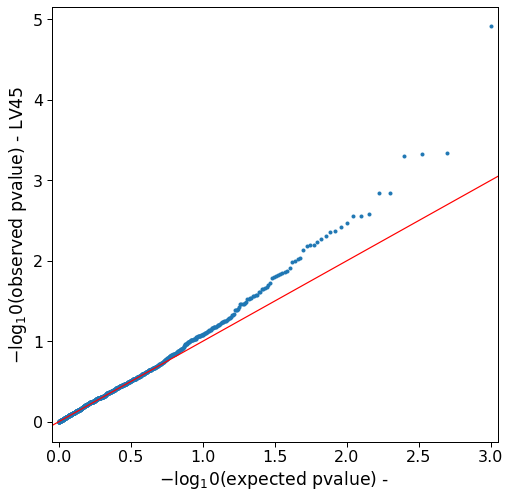

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.020039,0.012163,1.647518,0.099500,0.049750,random.pheno988
1220,LV234,0.000155,0.012149,0.012777,0.989806,0.494903,random.pheno589
2207,LV234,-0.012512,0.012140,-1.030657,0.302741,0.848630,random.pheno385
3194,LV234,0.008912,0.012143,0.733966,0.462996,0.231498,random.pheno5
4181,LV234,0.002307,0.012170,0.189574,0.849649,0.424825,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.017

In [43]:
show_prop(results, 0.05)

0.059

In [44]:
show_prop(results, 0.10)

0.109

In [45]:
show_prop(results, 0.15)

0.146

In [46]:
show_prop(results, 0.20)

0.178

### QQplot

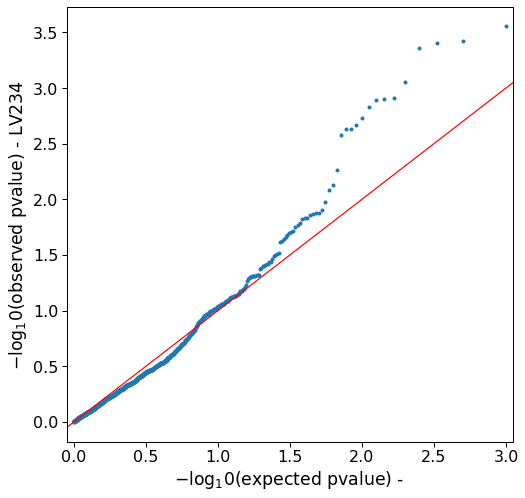

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.010607,0.012896,0.822527,0.410808,0.205404,random.pheno988
1833,LV847,0.003278,0.012917,0.253754,0.799694,0.399847,random.pheno589
2820,LV847,-0.015101,0.012896,-1.170989,0.241646,0.879177,random.pheno385
3807,LV847,0.007660,0.012884,0.594536,0.552175,0.276087,random.pheno5
4794,LV847,0.008070,0.012936,0.623855,0.532745,0.266373,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.024

In [54]:
show_prop(results, 0.05)

0.06

In [55]:
show_prop(results, 0.10)

0.101

In [56]:
show_prop(results, 0.15)

0.142

In [57]:
show_prop(results, 0.20)

0.19

### QQplot

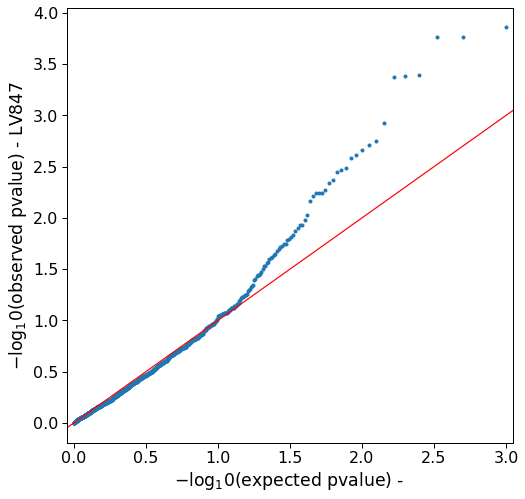

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.020894,0.013587,-1.537766,0.124155,0.937923,random.pheno988
1096,LV110,-0.007752,0.013595,-0.570202,0.568561,0.715720,random.pheno589
2083,LV110,-0.023587,0.013582,-1.736716,0.082485,0.958757,random.pheno385
3070,LV110,-0.011358,0.013545,-0.838550,0.401753,0.799123,random.pheno5
4057,LV110,-0.002071,0.013583,-0.152434,0.878849,0.560575,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.009

In [65]:
show_prop(results, 0.05)

0.037

In [66]:
show_prop(results, 0.10)

0.067

In [67]:
show_prop(results, 0.15)

0.107

In [68]:
show_prop(results, 0.20)

0.146

### QQplot

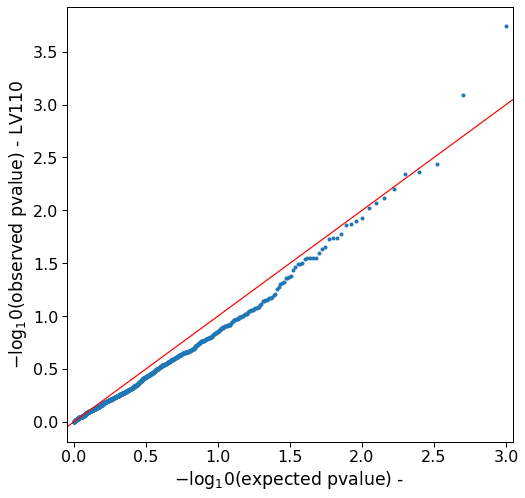

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014360,0.011846,1.212224,0.225471,0.112736,random.pheno988
1755,LV769,0.002044,0.011808,0.173098,0.862580,0.431290,random.pheno589
2742,LV769,0.001938,0.011823,0.163925,0.869795,0.434898,random.pheno385
3729,LV769,-0.015069,0.011822,-1.274658,0.202476,0.898762,random.pheno5
4716,LV769,-0.020010,0.011844,-1.689480,0.091176,0.954412,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.05

In [76]:
show_prop(results, 0.05)

0.14

In [77]:
show_prop(results, 0.10)

0.223

In [78]:
show_prop(results, 0.15)

0.294

In [79]:
show_prop(results, 0.20)

0.347

### QQplot

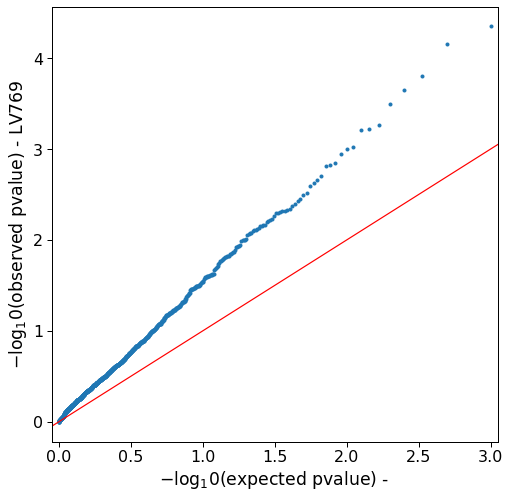

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.004973,0.014064,0.353626,0.723631,0.361815,random.pheno988
1786,LV800,-0.007164,0.014061,-0.509515,0.610409,0.694795,random.pheno589
2773,LV800,-0.003853,0.014079,-0.273697,0.784326,0.607837,random.pheno385
3760,LV800,-0.023073,0.014092,-1.637306,0.101615,0.949192,random.pheno5
4747,LV800,-0.012028,0.014031,-0.857297,0.391313,0.804344,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.008

In [87]:
show_prop(results, 0.05)

0.048

In [88]:
show_prop(results, 0.10)

0.086

In [89]:
show_prop(results, 0.15)

0.136

In [90]:
show_prop(results, 0.20)

0.19

### QQplot

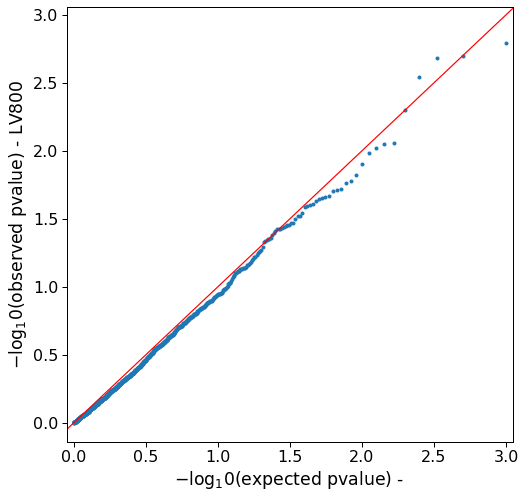

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
395,LV455,0.011,0.049,0.089
922,LV93,0.011,0.049,0.111
905,LV914,0.008,0.049,0.126
747,LV772,0.009,0.049,0.087
451,LV505,0.011,0.049,0.094
443,LV499,0.010,0.049,0.097
390,LV450,0.012,0.049,0.097
380,LV441,0.009,0.049,0.096
298,LV368,0.010,0.049,0.081
294,LV364,0.011,0.049,0.085


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.001248,0.010522,0.118590,0.905604,0.452802,random.pheno988
1398,LV412,-0.003262,0.010476,-0.311380,0.755522,0.622239,random.pheno589
2385,LV412,0.002794,0.010467,0.266917,0.789541,0.394771,random.pheno385
3372,LV412,-0.004607,0.010530,-0.437482,0.661776,0.669112,random.pheno5
4359,LV412,0.016482,0.010475,1.573369,0.115682,0.057841,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.011

In [100]:
show_prop(results, 0.05)

0.051

In [101]:
show_prop(results, 0.10)

0.098

In [102]:
show_prop(results, 0.15)

0.144

In [103]:
show_prop(results, 0.20)

0.188

### QQplot

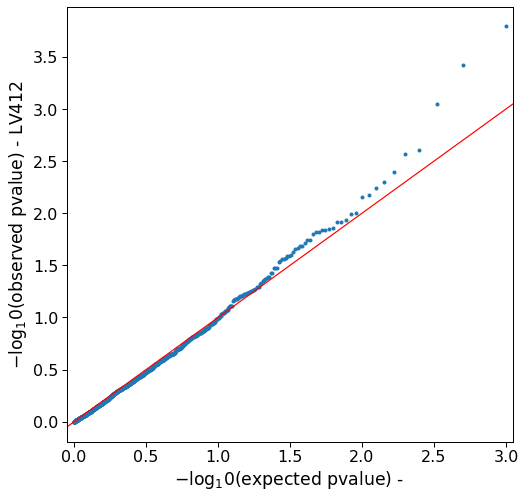

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.019052,0.012370,-1.540202,0.123560,0.938220,random.pheno988
1043,LV57,0.016605,0.012375,1.341806,0.179706,0.089853,random.pheno589
2030,LV57,0.018106,0.012377,1.462881,0.143549,0.071774,random.pheno385
3017,LV57,0.000365,0.012364,0.029550,0.976427,0.488213,random.pheno5
4004,LV57,0.013360,0.012337,1.082916,0.278886,0.139443,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.008

In [111]:
show_prop(results, 0.05)

0.056

In [112]:
show_prop(results, 0.10)

0.102

In [113]:
show_prop(results, 0.15)

0.145

In [114]:
show_prop(results, 0.20)

0.182

### QQplot

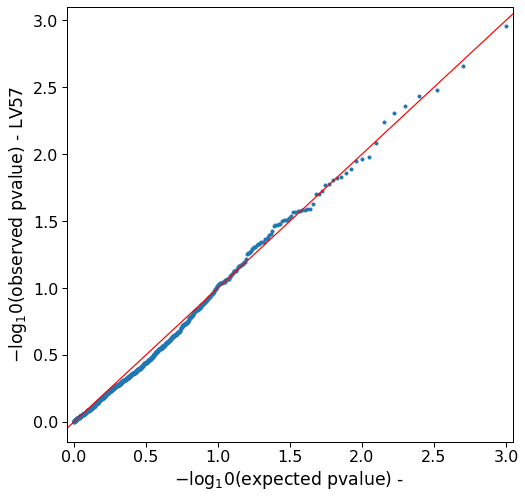

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.006633,0.011495,-0.577022,0.563945,0.718028,random.pheno988
1633,LV647,0.013955,0.011494,1.214099,0.224755,0.112377,random.pheno589
2620,LV647,0.012068,0.011492,1.050142,0.293692,0.146846,random.pheno385
3607,LV647,0.002723,0.011494,0.236954,0.812700,0.406350,random.pheno5
4594,LV647,0.014056,0.011466,1.225931,0.220269,0.110135,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.026

In [122]:
show_prop(results, 0.05)

0.075

In [123]:
show_prop(results, 0.10)

0.124

In [124]:
show_prop(results, 0.15)

0.17

In [125]:
show_prop(results, 0.20)

0.216

### QQplot

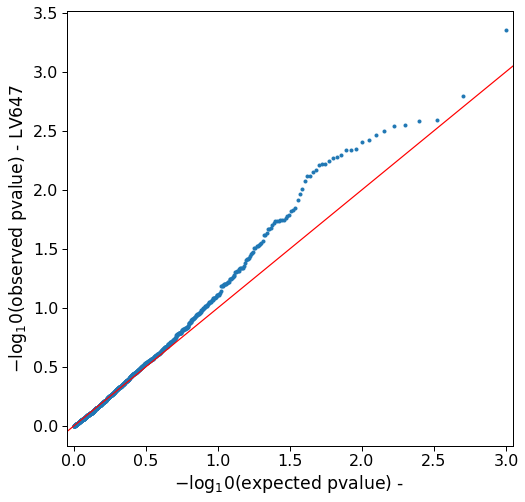

In [126]:
qqplot_unif(results)